# RNA/NMS Groups Counts

##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.9)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Functions

In [2]:
def rna_nms_table(df):
    npass = filter_df(df, "NMS Pass/Fail", "Pass")
    nfail = filter_df(df, "NMS Pass/Fail", "Fail")
    rpass = filter_df(df, "RNA Amp Pass/Fail", "Pass")
    rfail = filter_df(df, "RNA Amp Pass/Fail", "Fail")

    rfail_nfail = filter_df(rfail, "NMS Pass/Fail", "Fail")
    rfail_npass = filter_df(rfail, "NMS Pass/Fail", "Pass")
    rpass_nfail = filter_df(rpass, "NMS Pass/Fail", "Fail")
    rpass_npass = filter_df(rpass, "NMS Pass/Fail", "Pass")

    rfail_nfail["Group"] = "RNA Amp Fail/NMS Fail"
    rfail_npass["Group"] = "RNA Amp Fail/NMS Pass"
    rpass_nfail["Group"] = "RNA Amp Pass/NMS Fail"
    rpass_npass["Group"] = "RNA Amp Pass/NMS Pass"
    
    df = pd.concat([rfail_nfail, rfail_npass, rpass_nfail, rpass_npass])
    df["group_count"] = df.groupby(["Group", "Tree_call"])["Tree_call"].transform("count")
    df["group_total"] = df.groupby("Group")["Tree_call"].transform("count")
    df["proportion"] = df["group_count"] / df["group_total"] * 100
    return df

In [3]:
def create_proportion_table(df, index_col, val_col):
    df["group_count"] = df.groupby([index_col, val_col])[val_col].transform("count")
    df["group_total"] = df.groupby(index_col)[val_col].transform("count")
    df["proportion"] = df["group_count"] / df["group_total"] * 100
    return df

#### Paths/Fields

In [4]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/hl4_plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [5]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [6]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [7]:
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"})

In [8]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

In [9]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                       "sag" : "Sag Fraction", "tau": "τ(s)",
                       "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                       "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


##### Human Layer 4 DF

In [10]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4 = create_cond_df(h_l4, "region", ["FCx", "OCx", "PCx", "TCx"]) #473 rows

merged = merge_dataframes(h_l4, ephys, "cell_name", "name", "inner") #379 rows
merged.dropna(subset=ephys_list, inplace=True) #311 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4
INFO:temp_funcs:Created a conditional dataframe based on region containing ['FCx', 'OCx', 'PCx', 'TCx']
INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [11]:
d = dict()
for region_name in region_list:
    d[region_name] = filter_df(merged, "region", region_name)

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on region == OCx
INFO:temp_funcs:Filtered dataframe based on region == PCx
INFO:temp_funcs:Filtered dataframe based on region == TCx


##### Making groupby tables for RNA/NMS Groups

In [12]:
count_rn = rna_nms_table(merged)
count_fcx = rna_nms_table(d["FCx"])
count_ocx = rna_nms_table(d["OCx"])
count_pcx = rna_nms_table(d["PCx"])
count_tcx = rna_nms_table(d["TCx"])

INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel

##### Tables

In [13]:
merged = create_proportion_table(merged, "region", "Tree_call")
merged

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve,group_count,group_total,proportion
0,P8S4_180718_354_A01,H18.03.313.11.06.01.05,TCx_L4,0.689,Pass,12.936141,hIVSCC-MET,1.112490,Pass,Inh L1-2 PAX6 CDH12,1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H18.03.313.11.06.01.05,-63.207101,841.105652,0.147336,57.667624,3.333950,0.01846,0.362500,167,275,60.727273
3,P8S4_190618_356_A01,H19.03.314.12.07.01.01,TCx_L4,0.479,Pass,35.471986,hIVSCC-MET,0.988428,Pass,Inh L1-4 LAMP5 LCP2 (rosehip),0.984463,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.314.12.07.01.01,-60.490061,265.750021,0.094790,18.017630,2.811279,0.02972,0.296429,167,275,60.727273
4,P1S4_190813_005_A01,H19.03.319.12.07.01.03,TCx_L4,0.616,Pass,17.497605,hIVSCC-MET,1.372332,Pass,Inh L2-6 LAMP5 CA1 (Igtp),1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.319.12.07.01.03,-66.055191,249.234408,0.056897,15.964836,1.796395,0.02458,0.230000,167,275,60.727273
5,PAS4_190123_453_A01,H19.03.302.11.03.01.03,TCx_L4,0.666,Pass,16.073146,hIVSCC-MET,1.043932,Pass,Inh L2-6 LAMP5 CA1 (Igtp),0.960779,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.302.11.03.01.03,-59.083222,353.063971,0.022493,16.070204,2.099504,0.01042,0.348352,167,275,60.727273
7,PES4_190311_659_A01,H19.03.306.11.06.02.01,TCx_L4,0.605,Pass,17.100321,hIVSCC-MET,1.401790,Pass,Inh L2-4 VIP SPAG17,0.518578,GABAergic neuron,VIP,Core,TCx,L4,H19.03.306.11.06.02.01,-63.795358,294.788599,0.204165,21.670489,1.740138,0.07110,0.460714,167,275,60.727273
8,PFS4_190514_707_A01,H19.03.311.14.09.01.01,TCx_L4,0.626,Pass,22.534484,hIVSCC-MET,0.910007,Pass,Inh L4-6 SST GXYLT2,0.788271,GABAergic neuron,SST,Core,TCx,L4,H19.03.311.14.09.01.01,-69.826057,272.358090,0.078348,30.489864,2.643012,0.03758,0.215000,167,275,60.727273
9,P8S4_190709_359_A01,H19.03.315.11.01.01.03,TCx_L4,0.608,Pass,24.981095,hIVSCC-MET,0.760139,Pass,Inh L4-6 SST GXYLT2,0.805382,GABAergic neuron,SST,Core,TCx,L4,H19.03.315.11.01.01.03,-60.167358,455.456644,0.050051,34.739334,2.501881,0.01768,0.519231,167,275,60.727273
10,P8S4_190305_360_A01,H19.03.305.11.10.01.10,TCx_L4,0.736,Pass,22.357010,hIVSCC-MET,0.814408,Pass,Inh L4-5 SST STK32A,0.878520,GABAergic neuron,SST,Core,TCx,L4,H19.03.305.11.10.01.10,-60.089230,430.507749,0.300750,17.567443,2.292725,0.01114,0.996154,167,275,60.727273
11,PES4_190618_656_A01,H19.03.314.12.12.01.04,TCx_L4,0.586,Pass,37.454774,hIVSCC-MET,1.045758,Pass,Inh L4-5 SST STK32A,0.926072,GABAergic neuron,SST,Core,TCx,L4,H19.03.314.12.12.01.04,-67.620123,341.328114,0.205499,25.689827,1.507224,0.02812,0.798691,167,275,60.727273
12,P8S4_190425_355_A01,H19.03.310.11.06.02.04,FCx_L4,0.587,Pass,39.943973,hIVSCC-MET,0.715713,Pass,Inh L4-5 PVALB MEPE,0.752130,GABAergic neuron,PVALB,Core,FCx,L4,H19.03.310.11.06.02.04,-64.785444,255.134314,0.276781,19.006853,2.199861,0.01876,0.300000,17,31,54.838710


In [14]:
proportion_table = pd.pivot_table(count_rn, values="proportion", index=["Group"], columns="Tree_call", fill_value=0)
count_table = pd.pivot_table(count_rn, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)

In [15]:
count_table = pd.pivot_table(count_ocx, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)
count_table

Tree_call,Core,I2
Group,,
RNA Amp Pass/NMS Pass,2,1


In [16]:
count_table = pd.pivot_table(count_pcx, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)
count_table

Tree_call,I2
Group,
RNA Amp Pass/NMS Pass,2


##### Plots Region

In [17]:
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

In [18]:
count_table = pd.pivot_table(merged, values="group_count", index=["region"], columns="Tree_call", fill_value=0)
count_table

Tree_call,Core,I1,I2,I3,PoorQ
region,,,,,
FCx,17,6,3,0,5
OCx,2,0,1,0,0
PCx,0,0,2,0,0
TCx,167,45,20,1,42


[Text(0,0.5,'Percentage of Cell Proportion'), Text(0.5,0,'Groups')]

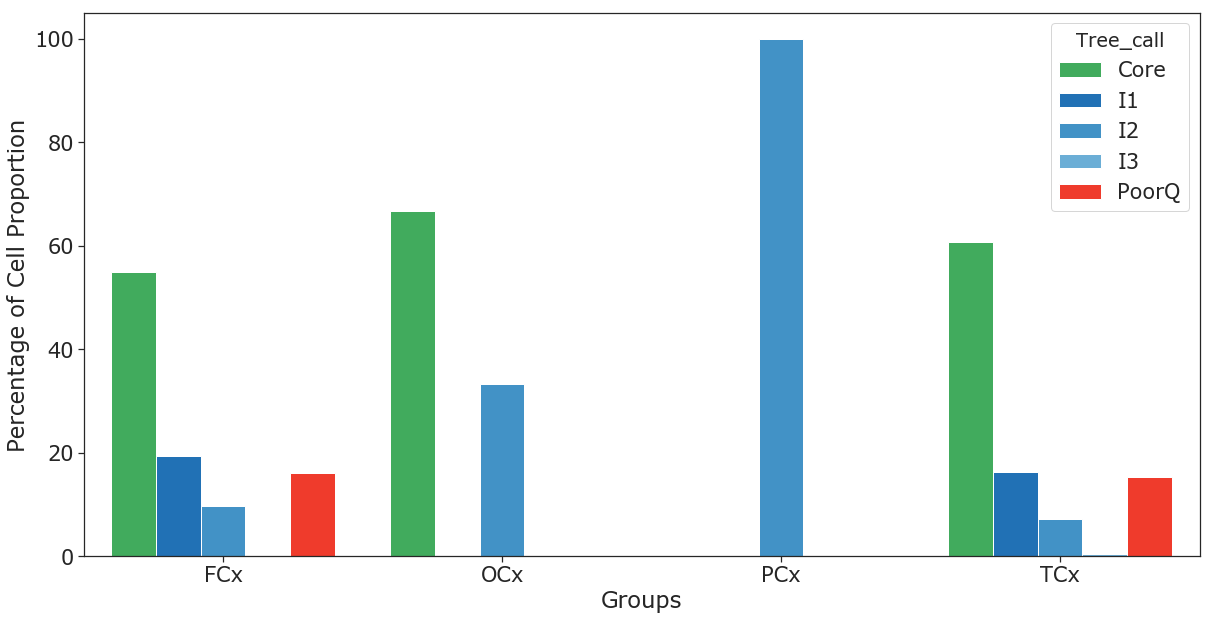

In [19]:
f, axes = plt.subplots(figsize=(20, 10))
    
ax = sns.barplot(x="region", y="proportion", data=merged, order=region_list,
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")

##### Plots RNA/NMS

In [20]:
count_table = pd.pivot_table(count_rn, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)
count_table

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Amp Fail/NMS Fail,0,0,0,0,19
RNA Amp Fail/NMS Pass,2,2,0,0,2
RNA Amp Pass/NMS Fail,1,0,0,0,15
RNA Amp Pass/NMS Pass,183,49,26,1,11


[Text(0,0.5,'Percentage of Cell Proportion'), Text(0.5,0,'Groups')]

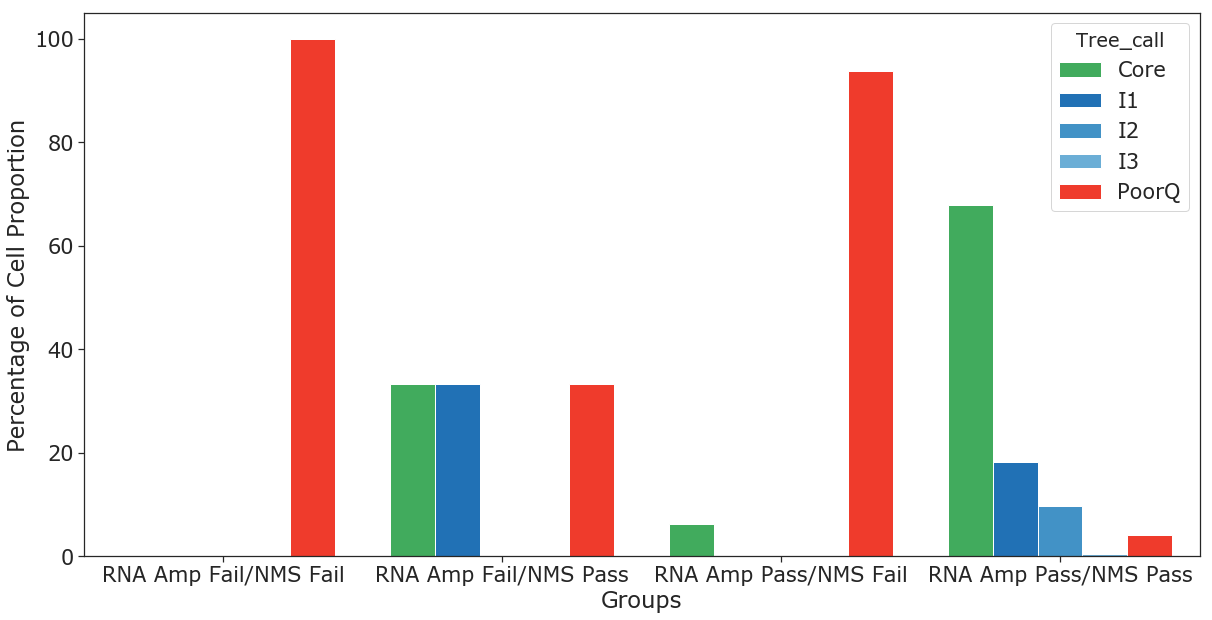

In [21]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_rn, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")

In [22]:
count_table = pd.pivot_table(count_fcx, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)
count_table

Tree_call,Core,I1,I2,PoorQ
Group,,,,
RNA Amp Fail/NMS Fail,0,0,0,2
RNA Amp Fail/NMS Pass,1,1,0,0
RNA Amp Pass/NMS Fail,0,0,0,2
RNA Amp Pass/NMS Pass,16,5,3,1


[Text(0,0.5,'Percentage of Cell Proportion'), Text(0.5,0,'Groups')]

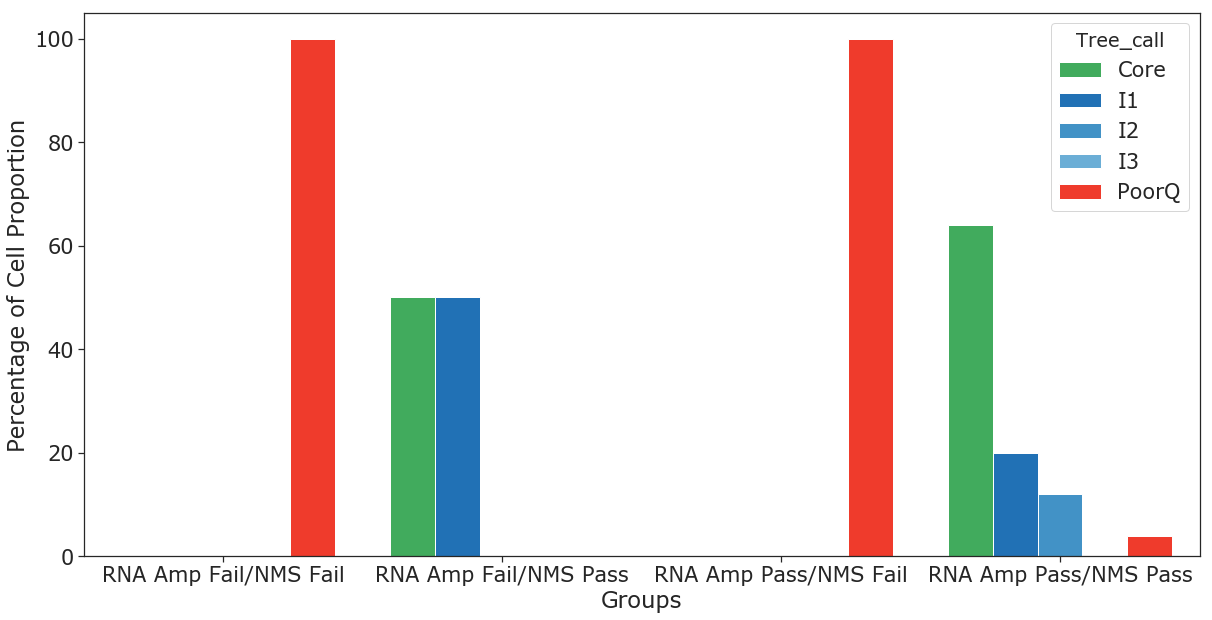

In [23]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_fcx, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")

In [24]:
count_table = pd.pivot_table(count_tcx, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)
count_table

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Amp Fail/NMS Fail,0,0,0,0,17
RNA Amp Fail/NMS Pass,1,1,0,0,2
RNA Amp Pass/NMS Fail,1,0,0,0,13
RNA Amp Pass/NMS Pass,165,44,20,1,10


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

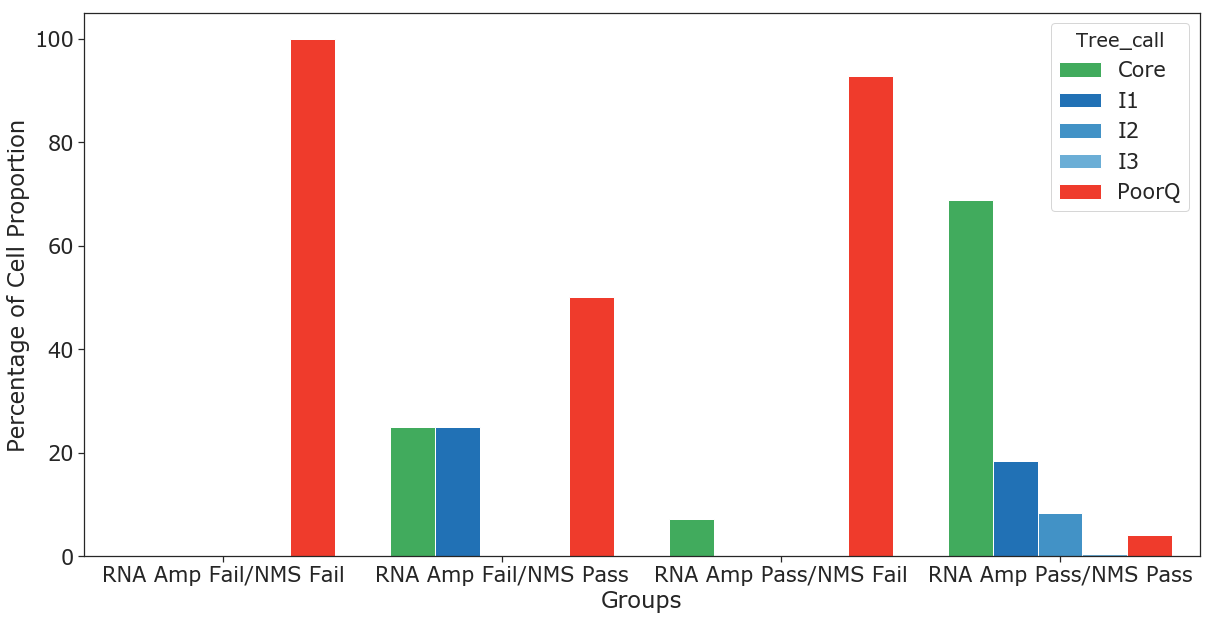

In [25]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_tcx, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")
plt.xticks(rotation=0)

In [35]:
d["FCx"]["subclass_label"].unique()

array(['PVALB', 'IT (L3-5)', 'IT (L4-6)', 'L5/6 NP', 'SST',
       'LAMP5/PAX6/Other', 'L5/6 CT'], dtype=object)

In [ ]:
gab_list = ["PVALB", "SST", "LAMP5/PAX6/Other"]
glu_list - ["IT (L3-5)", "IT (L4-6)", "L5/6 NP", "L5/6 CT"]

In [ ]:
gab_dict = {}
for gab in gab_list:
    gab_dict[gab] = "#2171b5"
    
glu_dict = {}
for glu in glu_list:
    glu_dict[glu] = "#ef3b2c"

In [26]:
broad_class_colors = {"GABAergic neuron": "#2171b5", "Glutamatergic neuron": "#ef3b2c"}
region_colors = {"FCx": "#2171b5", "TCx": "#ef3b2c"}

subclass_colors = glu_dict + gab_dict

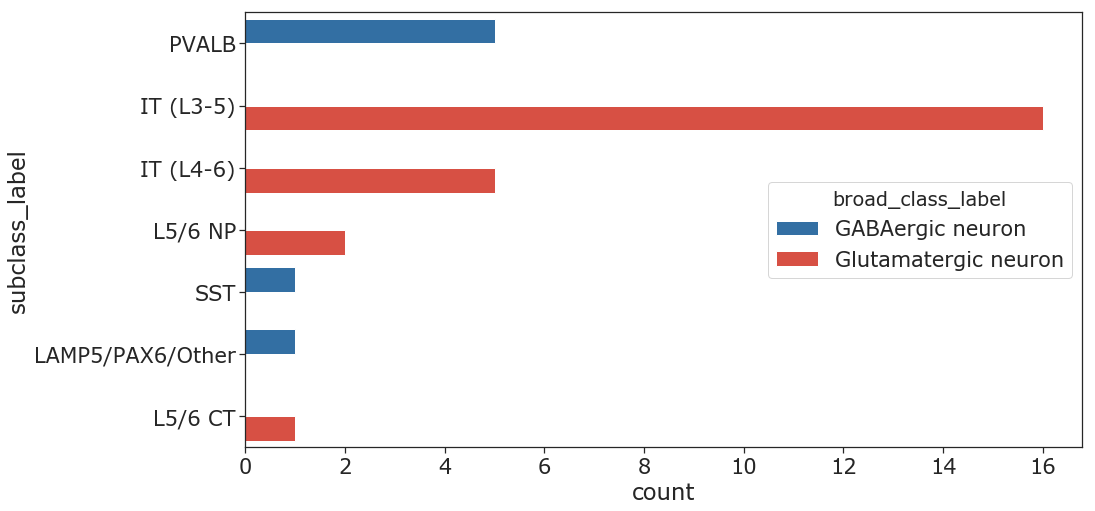

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=d["FCx"], y="subclass_label", hue="broad_class_label", palette=subclass_class_colors)

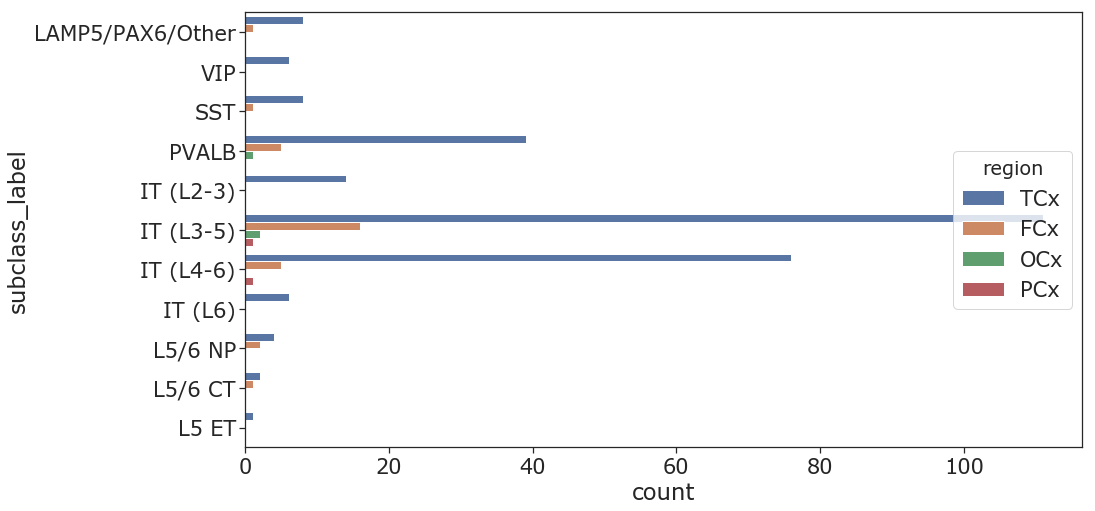

In [32]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=merged, y="subclass_label", hue="region") #palette=broad_class_colors)

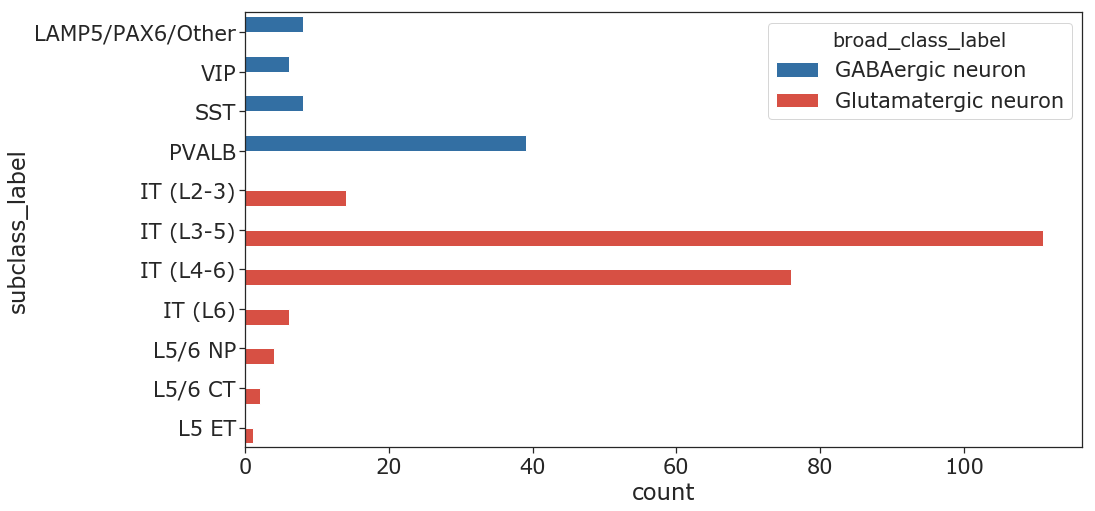

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=d["TCx"], y="subclass_label", hue="broad_class_label", palette=broad_class_colors)